In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "3" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

In [3]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [4]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    


ep=311
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
ncluster=8
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [5]:
subclusternumbers=[4,6,8,6,6,6,6,4]
clusterRes_sub=np.zeros(clusterRes.size)-1
for i in np.unique(clusterRes):
    subcluster=subclusternumbers[i]
    subclustersavedir=os.path.join(clustersavedir,savenamecluster+'_subcluster'+str(i))

    savenameclustersub='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(ep)+plotsavenameAdd
    with open(os.path.join(subclustersavedir,savenameclustersub), 'rb') as output:
        subclusterRes=pickle.load(output)
        
    clusterRes_sub[clusterRes==i]=subclusterRes

print(np.sum(clusterRes_sub==-1))

0


In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [7]:
#load latent
datadir='/media/xinyi/dcis2idc/data'
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)
    
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*3*3
fc_dim2=6000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae'

name='exp0'
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name

# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_sharded':
    modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
    use_cuda=False

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

ep=311

#compute latent

use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()



In [8]:
#load duct membership
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
alllabels_sub=None
alllatents=None
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s):
        continue
    print(s)
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0

    stats_s=pd.read_csv(path_s)
    stats_s.index=stats_s.loc[:,'label']
    stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()

#         ssplit=s.split('_')
    slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
    slabels_sub=clusterRes_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    
    latent_s=latent[plottingIdx_i.astype(int)][allImgNames[plottingIdx_i.astype(int)]==s]

    if allstats is None:
        allstats=stats_s>0
        alllabels=np.copy(slabels)
        alllabels_sub=np.copy(slabels_sub)
        alllatents=latent_s
    else:
        allstats=np.concatenate((allstats,stats_s>0),axis=0)
        alllabels=np.concatenate((alllabels,np.copy(slabels)))
        alllabels_sub=np.concatenate((alllabels_sub,np.copy(slabels_sub)))
        alllatents=np.concatenate((alllatents,latent_s))


br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_C1
br301_4_cytokeratin_555_aSMA_647_hoechst_C2
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_C5
br301_4_cytokeratin_55

In [9]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=6000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=1024
fc_dim2=1024
fc_dim3=1024


dropout=0.01
kl_weight=0.0000001

name='exp0_ductClf_latent_subclusters_'+savenamecluster+'fcl3'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [26]:
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(stats_sub[trainIdx_i]).cuda().float()
            labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred.flatten(),labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(stats_sub[valIdx_i]).cuda().float()
                labels=torch.tensor(labels_sub[valIdx_i]).cuda().float()
                
            pred= model(valInput)

            loss_val=lossCE(pred.flatten(),labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    if epoch%50==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all

In [12]:
modelcnn.cpu()
modelcnn=None
gc.collect()

190

In [25]:
torch.cuda.empty_cache()

In [18]:
allstats=allstats.astype(int)

Epoch: 0000 loss_train: 0.6888 loss_val: 0.6826
Epoch: 0050 loss_train: 0.5751 loss_val: 0.5641
Epoch: 0100 loss_train: 0.4740 loss_val: 0.5535
Epoch: 0150 loss_train: 0.3943 loss_val: 0.6797
Epoch: 0200 loss_train: 0.2941 loss_val: 0.7294
Epoch: 0250 loss_train: 0.2742 loss_val: 0.9243
Epoch: 0300 loss_train: 0.2739 loss_val: 0.9598
Epoch: 0350 loss_train: 0.2119 loss_val: 1.1737
Epoch: 0400 loss_train: 0.2165 loss_val: 1.2690
Epoch: 0450 loss_train: 0.1778 loss_val: 1.4507
Epoch: 0500 loss_train: 0.1742 loss_val: 1.5164
Epoch: 0550 loss_train: 0.1730 loss_val: 1.4467
Epoch: 0600 loss_train: 0.1744 loss_val: 1.1989
Epoch: 0650 loss_train: 0.1955 loss_val: 1.2349
Epoch: 0700 loss_train: 0.1359 loss_val: 1.4589
Epoch: 0750 loss_train: 0.1443 loss_val: 1.6302
Epoch: 0800 loss_train: 0.1383 loss_val: 1.7870
Epoch: 0850 loss_train: 0.1214 loss_val: 1.7814
Epoch: 0900 loss_train: 0.1497 loss_val: 1.5939
Epoch: 0950 loss_train: 0.1321 loss_val: 1.6143
Epoch: 1000 loss_train: 0.1186 loss_val:

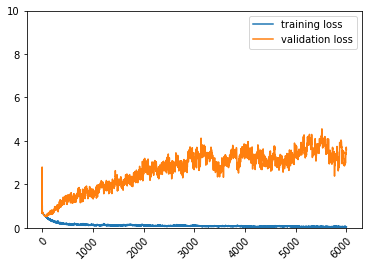

Epoch: 0000 loss_train: 0.8995 loss_val: 0.8763
Epoch: 0050 loss_train: 0.7518 loss_val: 0.8361
Epoch: 0100 loss_train: 0.6170 loss_val: 1.1082
Epoch: 0150 loss_train: 0.4957 loss_val: 1.2871
Epoch: 0200 loss_train: 0.4788 loss_val: 1.5439
Epoch: 0250 loss_train: 0.3892 loss_val: 2.0932
Epoch: 0300 loss_train: 0.3214 loss_val: 2.3303
Epoch: 0350 loss_train: 0.2973 loss_val: 2.0725
Epoch: 0400 loss_train: 0.2888 loss_val: 2.1549
Epoch: 0450 loss_train: 0.2733 loss_val: 2.3553
Epoch: 0500 loss_train: 0.2254 loss_val: 2.8613
Epoch: 0550 loss_train: 0.2676 loss_val: 2.2601
Epoch: 0600 loss_train: 0.2939 loss_val: 2.5899
Epoch: 0650 loss_train: 0.1954 loss_val: 3.4222
Epoch: 0700 loss_train: 0.2518 loss_val: 2.9706
Epoch: 0750 loss_train: 0.1959 loss_val: 2.7328
Epoch: 0800 loss_train: 0.2034 loss_val: 3.3087
Epoch: 0850 loss_train: 0.1823 loss_val: 3.4896
Epoch: 0900 loss_train: 0.2114 loss_val: 2.9302
Epoch: 0950 loss_train: 0.1774 loss_val: 2.9576
Epoch: 1000 loss_train: 0.2043 loss_val:

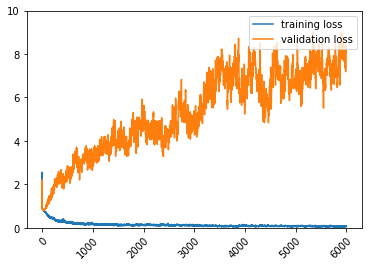

Epoch: 0000 loss_train: 0.8745 loss_val: 0.8829
Epoch: 0050 loss_train: 0.7062 loss_val: 0.8881
Epoch: 0100 loss_train: 0.5317 loss_val: 0.9134
Epoch: 0150 loss_train: 0.4178 loss_val: 1.3995
Epoch: 0200 loss_train: 0.3339 loss_val: 1.3884
Epoch: 0250 loss_train: 0.3130 loss_val: 1.4831
Epoch: 0300 loss_train: 0.2337 loss_val: 2.0507
Epoch: 0350 loss_train: 0.2278 loss_val: 2.6695
Epoch: 0400 loss_train: 0.2404 loss_val: 2.1854
Epoch: 0450 loss_train: 0.1705 loss_val: 2.2313
Epoch: 0500 loss_train: 0.2252 loss_val: 2.6388
Epoch: 0550 loss_train: 0.1865 loss_val: 2.9308
Epoch: 0600 loss_train: 0.1709 loss_val: 2.1984
Epoch: 0650 loss_train: 0.1503 loss_val: 2.3664
Epoch: 0700 loss_train: 0.1404 loss_val: 2.5633
Epoch: 0750 loss_train: 0.1220 loss_val: 3.6303
Epoch: 0800 loss_train: 0.1906 loss_val: 2.9901
Epoch: 0850 loss_train: 0.1349 loss_val: 3.6217
Epoch: 0900 loss_train: 0.1100 loss_val: 3.6284
Epoch: 0950 loss_train: 0.1317 loss_val: 4.2745
Epoch: 1000 loss_train: 0.1336 loss_val:

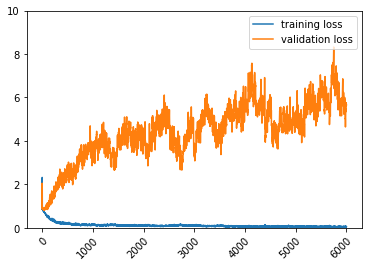

Epoch: 0000 loss_train: 0.6903 loss_val: 0.6777
Epoch: 0050 loss_train: 0.5816 loss_val: 0.5969
Epoch: 0100 loss_train: 0.4736 loss_val: 0.6866
Epoch: 0150 loss_train: 0.4018 loss_val: 0.7590
Epoch: 0200 loss_train: 0.3380 loss_val: 0.9280
Epoch: 0250 loss_train: 0.2615 loss_val: 1.0364
Epoch: 0300 loss_train: 0.2328 loss_val: 1.1321
Epoch: 0350 loss_train: 0.2003 loss_val: 1.3891
Epoch: 0400 loss_train: 0.2194 loss_val: 1.2842
Epoch: 0450 loss_train: 0.1791 loss_val: 1.3360
Epoch: 0500 loss_train: 0.1717 loss_val: 1.3798
Epoch: 0550 loss_train: 0.1503 loss_val: 1.3408
Epoch: 0600 loss_train: 0.1433 loss_val: 1.4674
Epoch: 0650 loss_train: 0.1484 loss_val: 1.7075
Epoch: 0700 loss_train: 0.1372 loss_val: 1.7319
Epoch: 0750 loss_train: 0.1223 loss_val: 1.6069
Epoch: 0800 loss_train: 0.1425 loss_val: 1.7426
Epoch: 0850 loss_train: 0.1233 loss_val: 1.6495
Epoch: 0900 loss_train: 0.1094 loss_val: 1.7032
Epoch: 0950 loss_train: 0.1260 loss_val: 1.7738
Epoch: 1000 loss_train: 0.1000 loss_val:

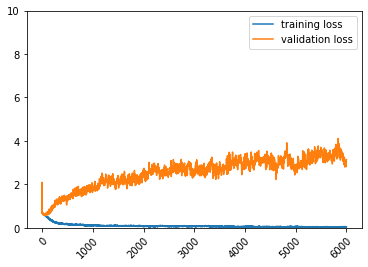

Epoch: 0000 loss_train: 1.0647 loss_val: 1.0744
Epoch: 0050 loss_train: 0.9361 loss_val: 0.8748
Epoch: 0100 loss_train: 0.8675 loss_val: 0.8422
Epoch: 0150 loss_train: 0.8334 loss_val: 0.8383
Epoch: 0200 loss_train: 0.7544 loss_val: 1.0385
Epoch: 0250 loss_train: 0.7384 loss_val: 0.8624
Epoch: 0300 loss_train: 0.6921 loss_val: 1.0183
Epoch: 0350 loss_train: 0.6427 loss_val: 1.1428
Epoch: 0400 loss_train: 0.6142 loss_val: 1.4333
Epoch: 0450 loss_train: 0.6029 loss_val: 1.4657
Epoch: 0500 loss_train: 0.5915 loss_val: 1.3317
Epoch: 0550 loss_train: 0.5206 loss_val: 1.7040
Epoch: 0600 loss_train: 0.6007 loss_val: 1.6383
Epoch: 0650 loss_train: 0.5598 loss_val: 1.7991
Epoch: 0700 loss_train: 0.4932 loss_val: 1.9312
Epoch: 0750 loss_train: 0.4649 loss_val: 1.9267
Epoch: 0800 loss_train: 0.4748 loss_val: 2.5743
Epoch: 0850 loss_train: 0.4381 loss_val: 2.5232
Epoch: 0900 loss_train: 0.4867 loss_val: 2.9874
Epoch: 0950 loss_train: 0.4536 loss_val: 2.8851
Epoch: 1000 loss_train: 0.4173 loss_val:

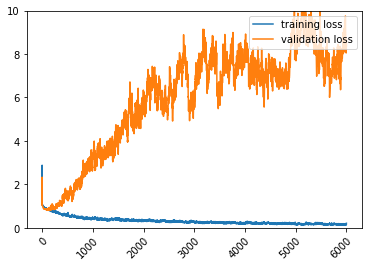

Epoch: 0000 loss_train: 1.1492 loss_val: 1.1483
Epoch: 0050 loss_train: 1.1331 loss_val: 1.1566
Epoch: 0100 loss_train: 1.0870 loss_val: 1.1696
Epoch: 0150 loss_train: 1.0639 loss_val: 1.1970
Epoch: 0200 loss_train: 1.0596 loss_val: 1.2457
Epoch: 0250 loss_train: 0.9999 loss_val: 1.1961
Epoch: 0300 loss_train: 0.9629 loss_val: 1.2691
Epoch: 0350 loss_train: 0.9650 loss_val: 1.4018
Epoch: 0400 loss_train: 0.9311 loss_val: 1.3452
Epoch: 0450 loss_train: 0.9533 loss_val: 1.3388
Epoch: 0500 loss_train: 0.9053 loss_val: 1.4560
Epoch: 0550 loss_train: 0.8573 loss_val: 1.6688
Epoch: 0600 loss_train: 0.9177 loss_val: 1.6218
Epoch: 0650 loss_train: 0.9147 loss_val: 1.1603
Epoch: 0700 loss_train: 0.8989 loss_val: 1.1589
Epoch: 0750 loss_train: 0.8796 loss_val: 1.3193
Epoch: 0800 loss_train: 0.8797 loss_val: 1.5902
Epoch: 0850 loss_train: 0.9172 loss_val: 1.3189
Epoch: 0900 loss_train: 0.8848 loss_val: 1.4102
Epoch: 0950 loss_train: 0.8983 loss_val: 1.3353
Epoch: 1000 loss_train: 0.8532 loss_val:

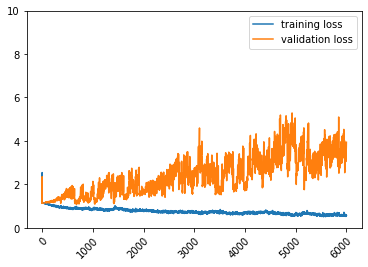

Epoch: 0000 loss_train: 1.1148 loss_val: 1.1535
Epoch: 0050 loss_train: 1.0373 loss_val: 1.1399
Epoch: 0100 loss_train: 0.9800 loss_val: 1.2004
Epoch: 0150 loss_train: 0.9566 loss_val: 1.2743
Epoch: 0200 loss_train: 0.9284 loss_val: 1.2018
Epoch: 0250 loss_train: 0.9141 loss_val: 1.2111
Epoch: 0300 loss_train: 0.8512 loss_val: 1.1827
Epoch: 0350 loss_train: 0.8349 loss_val: 1.3037
Epoch: 0400 loss_train: 0.8137 loss_val: 1.4582
Epoch: 0450 loss_train: 0.7988 loss_val: 1.4017
Epoch: 0500 loss_train: 0.7556 loss_val: 1.5278
Epoch: 0550 loss_train: 0.7590 loss_val: 1.6243
Epoch: 0600 loss_train: 0.7170 loss_val: 1.6438
Epoch: 0650 loss_train: 0.6917 loss_val: 1.8717
Epoch: 0700 loss_train: 0.6997 loss_val: 1.9139
Epoch: 0750 loss_train: 0.6759 loss_val: 2.5438
Epoch: 0800 loss_train: 0.6389 loss_val: 2.2134
Epoch: 0850 loss_train: 0.6406 loss_val: 2.7425
Epoch: 0900 loss_train: 0.6560 loss_val: 2.6228
Epoch: 0950 loss_train: 0.6046 loss_val: 2.7533
Epoch: 1000 loss_train: 0.6233 loss_val:

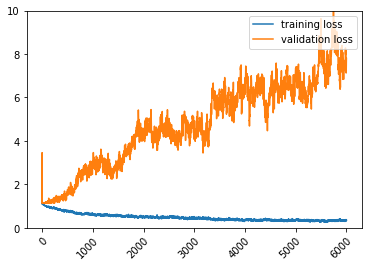

Epoch: 0000 loss_train: 1.1243 loss_val: 1.1316
Epoch: 0050 loss_train: 1.0715 loss_val: 1.0236
Epoch: 0100 loss_train: 1.0051 loss_val: 1.0681
Epoch: 0150 loss_train: 0.9291 loss_val: 1.1052
Epoch: 0200 loss_train: 0.8936 loss_val: 1.2965
Epoch: 0250 loss_train: 0.8845 loss_val: 1.1682
Epoch: 0300 loss_train: 0.8260 loss_val: 1.3218
Epoch: 0350 loss_train: 0.7962 loss_val: 1.5068
Epoch: 0400 loss_train: 0.7893 loss_val: 1.5821
Epoch: 0450 loss_train: 0.8588 loss_val: 1.5142
Epoch: 0500 loss_train: 0.7240 loss_val: 1.6417
Epoch: 0550 loss_train: 0.7228 loss_val: 1.6819
Epoch: 0600 loss_train: 0.6829 loss_val: 2.0581
Epoch: 0650 loss_train: 0.7165 loss_val: 1.8854
Epoch: 0700 loss_train: 0.6940 loss_val: 2.2408
Epoch: 0750 loss_train: 0.6827 loss_val: 2.6483
Epoch: 0800 loss_train: 0.6766 loss_val: 2.4592
Epoch: 0850 loss_train: 0.6979 loss_val: 2.1281
Epoch: 0900 loss_train: 0.6455 loss_val: 2.1282
Epoch: 0950 loss_train: 0.6696 loss_val: 2.2154
Epoch: 1000 loss_train: 0.5893 loss_val:

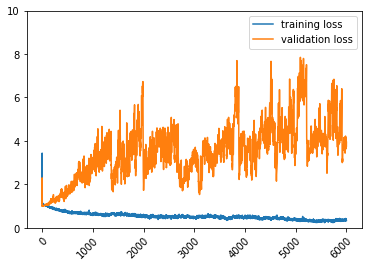

Epoch: 0000 loss_train: 1.1228 loss_val: 1.2238
Epoch: 0050 loss_train: 0.9703 loss_val: 1.1618
Epoch: 0100 loss_train: 0.8390 loss_val: 1.1710
Epoch: 0150 loss_train: 0.7544 loss_val: 1.2425
Epoch: 0200 loss_train: 0.7293 loss_val: 1.4541
Epoch: 0250 loss_train: 0.6476 loss_val: 1.5861
Epoch: 0300 loss_train: 0.6303 loss_val: 1.6163
Epoch: 0350 loss_train: 0.5274 loss_val: 2.1178
Epoch: 0400 loss_train: 0.5394 loss_val: 1.9185
Epoch: 0450 loss_train: 0.5440 loss_val: 1.7289
Epoch: 0500 loss_train: 0.5221 loss_val: 1.9153
Epoch: 0550 loss_train: 0.4707 loss_val: 2.8250
Epoch: 0600 loss_train: 0.5002 loss_val: 3.1282
Epoch: 0650 loss_train: 0.4225 loss_val: 2.6124
Epoch: 0700 loss_train: 0.3848 loss_val: 2.9549
Epoch: 0750 loss_train: 0.4116 loss_val: 2.9248
Epoch: 0800 loss_train: 0.3891 loss_val: 3.2777
Epoch: 0850 loss_train: 0.2950 loss_val: 3.2332
Epoch: 0900 loss_train: 0.3523 loss_val: 3.6614
Epoch: 0950 loss_train: 0.3355 loss_val: 3.5775
Epoch: 1000 loss_train: 0.3281 loss_val:

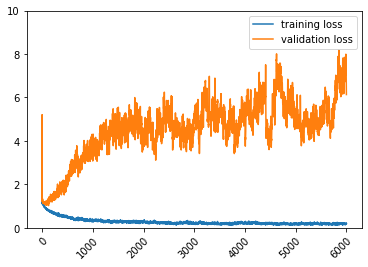

Epoch: 0000 loss_train: 1.0857 loss_val: 1.1053
Epoch: 0050 loss_train: 0.9648 loss_val: 0.9380
Epoch: 0100 loss_train: 0.9084 loss_val: 0.9317
Epoch: 0150 loss_train: 0.8139 loss_val: 0.9703
Epoch: 0200 loss_train: 0.7169 loss_val: 1.0015
Epoch: 0250 loss_train: 0.7606 loss_val: 1.0199
Epoch: 0300 loss_train: 0.6973 loss_val: 1.0465
Epoch: 0350 loss_train: 0.6821 loss_val: 1.1086
Epoch: 0400 loss_train: 0.6669 loss_val: 1.1531
Epoch: 0450 loss_train: 0.6425 loss_val: 1.1707
Epoch: 0500 loss_train: 0.5810 loss_val: 1.2383
Epoch: 0550 loss_train: 0.5885 loss_val: 1.1653
Epoch: 0600 loss_train: 0.6267 loss_val: 1.2232
Epoch: 0650 loss_train: 0.5919 loss_val: 1.1660
Epoch: 0700 loss_train: 0.5495 loss_val: 1.1992
Epoch: 0750 loss_train: 0.6072 loss_val: 1.1471
Epoch: 0800 loss_train: 0.5621 loss_val: 1.4689
Epoch: 0850 loss_train: 0.5326 loss_val: 1.3121
Epoch: 0900 loss_train: 0.4723 loss_val: 1.5852
Epoch: 0950 loss_train: 0.5551 loss_val: 1.3234
Epoch: 1000 loss_train: 0.4911 loss_val:

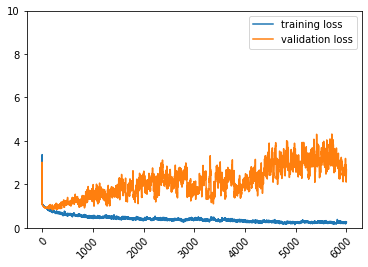

Epoch: 0000 loss_train: 0.6880 loss_val: 0.6820
Epoch: 0050 loss_train: 0.5350 loss_val: 0.6956
Epoch: 0100 loss_train: 0.4389 loss_val: 1.0030
Epoch: 0150 loss_train: 0.3429 loss_val: 1.3826
Epoch: 0200 loss_train: 0.3083 loss_val: 1.4734
Epoch: 0250 loss_train: 0.2456 loss_val: 1.9955
Epoch: 0300 loss_train: 0.2559 loss_val: 1.9247
Epoch: 0350 loss_train: 0.1901 loss_val: 2.0762
Epoch: 0400 loss_train: 0.2237 loss_val: 2.0935
Epoch: 0450 loss_train: 0.1903 loss_val: 2.2042
Epoch: 0500 loss_train: 0.1723 loss_val: 2.6317
Epoch: 0550 loss_train: 0.1741 loss_val: 2.6493
Epoch: 0600 loss_train: 0.1532 loss_val: 3.1064
Epoch: 0650 loss_train: 0.1669 loss_val: 3.1322
Epoch: 0700 loss_train: 0.1792 loss_val: 3.2666
Epoch: 0750 loss_train: 0.1263 loss_val: 3.0480
Epoch: 0800 loss_train: 0.1501 loss_val: 3.2901
Epoch: 0850 loss_train: 0.1348 loss_val: 3.4051
Epoch: 0900 loss_train: 0.1164 loss_val: 4.1740
Epoch: 0950 loss_train: 0.1193 loss_val: 4.3692
Epoch: 1000 loss_train: 0.1180 loss_val:

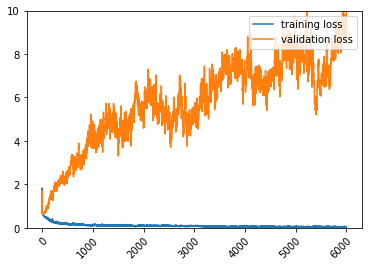

Epoch: 0000 loss_train: 1.0256 loss_val: 1.0645
Epoch: 0050 loss_train: 0.8505 loss_val: 1.0863
Epoch: 0100 loss_train: 0.6721 loss_val: 1.6303
Epoch: 0150 loss_train: 0.4841 loss_val: 2.2453
Epoch: 0200 loss_train: 0.4216 loss_val: 2.6945
Epoch: 0250 loss_train: 0.3971 loss_val: 3.0018
Epoch: 0300 loss_train: 0.3856 loss_val: 2.6459
Epoch: 0350 loss_train: 0.4199 loss_val: 2.7742
Epoch: 0400 loss_train: 0.2838 loss_val: 3.0713
Epoch: 0450 loss_train: 0.3508 loss_val: 2.8233
Epoch: 0500 loss_train: 0.2365 loss_val: 3.7515
Epoch: 0550 loss_train: 0.3043 loss_val: 3.5483
Epoch: 0600 loss_train: 0.2759 loss_val: 3.5011
Epoch: 0650 loss_train: 0.2051 loss_val: 3.9062
Epoch: 0700 loss_train: 0.3110 loss_val: 4.4395
Epoch: 0750 loss_train: 0.2229 loss_val: 3.8108
Epoch: 0800 loss_train: 0.2848 loss_val: 3.5317
Epoch: 0850 loss_train: 0.2527 loss_val: 3.5135
Epoch: 0900 loss_train: 0.2430 loss_val: 3.6608
Epoch: 0950 loss_train: 0.2417 loss_val: 4.8068
Epoch: 1000 loss_train: 0.1607 loss_val:

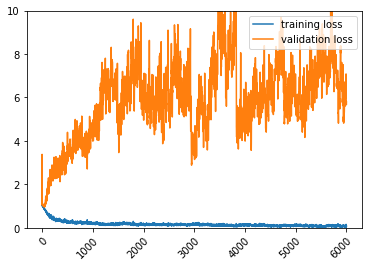

Epoch: 0000 loss_train: 0.7050 loss_val: 0.6884
Epoch: 0050 loss_train: 0.5593 loss_val: 0.5590
Epoch: 0100 loss_train: 0.4272 loss_val: 0.6651
Epoch: 0150 loss_train: 0.3219 loss_val: 0.5753
Epoch: 0200 loss_train: 0.2698 loss_val: 1.0026
Epoch: 0250 loss_train: 0.2712 loss_val: 1.1278
Epoch: 0300 loss_train: 0.2328 loss_val: 1.1892
Epoch: 0350 loss_train: 0.2300 loss_val: 0.9454
Epoch: 0400 loss_train: 0.1737 loss_val: 1.2961
Epoch: 0450 loss_train: 0.1923 loss_val: 1.2231
Epoch: 0500 loss_train: 0.1919 loss_val: 1.4064
Epoch: 0550 loss_train: 0.1571 loss_val: 1.4369
Epoch: 0600 loss_train: 0.1345 loss_val: 1.3678
Epoch: 0650 loss_train: 0.1505 loss_val: 1.7983
Epoch: 0700 loss_train: 0.1065 loss_val: 2.1047
Epoch: 0750 loss_train: 0.0930 loss_val: 2.1609
Epoch: 0800 loss_train: 0.1188 loss_val: 2.3601
Epoch: 0850 loss_train: 0.0942 loss_val: 2.4918
Epoch: 0900 loss_train: 0.1241 loss_val: 2.4123
Epoch: 0950 loss_train: 0.1107 loss_val: 2.2728
Epoch: 1000 loss_train: 0.1034 loss_val:

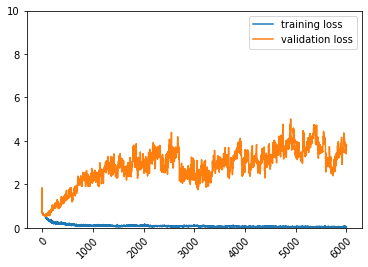

Epoch: 0000 loss_train: 0.8236 loss_val: 0.8180
Epoch: 0050 loss_train: 0.6675 loss_val: 0.7020
Epoch: 0100 loss_train: 0.5946 loss_val: 0.7238
Epoch: 0150 loss_train: 0.5590 loss_val: 0.8386
Epoch: 0200 loss_train: 0.4668 loss_val: 0.8861
Epoch: 0250 loss_train: 0.4073 loss_val: 0.9477
Epoch: 0300 loss_train: 0.3778 loss_val: 0.9947
Epoch: 0350 loss_train: 0.3239 loss_val: 1.1290
Epoch: 0400 loss_train: 0.2823 loss_val: 1.3098
Epoch: 0450 loss_train: 0.2857 loss_val: 1.2844
Epoch: 0500 loss_train: 0.2908 loss_val: 1.3986
Epoch: 0550 loss_train: 0.2043 loss_val: 1.8736
Epoch: 0600 loss_train: 0.2329 loss_val: 1.5975
Epoch: 0650 loss_train: 0.2255 loss_val: 1.6102
Epoch: 0700 loss_train: 0.1994 loss_val: 2.0647
Epoch: 0750 loss_train: 0.2102 loss_val: 1.9622
Epoch: 0800 loss_train: 0.1851 loss_val: 1.9812
Epoch: 0850 loss_train: 0.1703 loss_val: 2.4037
Epoch: 0900 loss_train: 0.1476 loss_val: 2.1949
Epoch: 0950 loss_train: 0.1610 loss_val: 2.2593
Epoch: 1000 loss_train: 0.1443 loss_val:

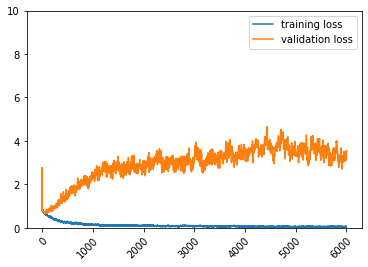

Epoch: 0000 loss_train: 0.6836 loss_val: 0.6640
Epoch: 0050 loss_train: 0.5649 loss_val: 0.6983
Epoch: 0100 loss_train: 0.4598 loss_val: 0.8090
Epoch: 0150 loss_train: 0.3410 loss_val: 1.0192
Epoch: 0200 loss_train: 0.2727 loss_val: 1.3278
Epoch: 0250 loss_train: 0.2272 loss_val: 1.4931
Epoch: 0300 loss_train: 0.2111 loss_val: 1.7204
Epoch: 0350 loss_train: 0.2005 loss_val: 1.8480
Epoch: 0400 loss_train: 0.1891 loss_val: 1.7970
Epoch: 0450 loss_train: 0.1776 loss_val: 1.9640
Epoch: 0500 loss_train: 0.1751 loss_val: 1.7343
Epoch: 0550 loss_train: 0.1713 loss_val: 1.9174
Epoch: 0600 loss_train: 0.1312 loss_val: 2.1327
Epoch: 0650 loss_train: 0.1223 loss_val: 2.0798
Epoch: 0700 loss_train: 0.1387 loss_val: 2.4680
Epoch: 0750 loss_train: 0.1678 loss_val: 2.3509
Epoch: 0800 loss_train: 0.1432 loss_val: 2.8513
Epoch: 0850 loss_train: 0.1035 loss_val: 2.5673
Epoch: 0900 loss_train: 0.1301 loss_val: 2.9674
Epoch: 0950 loss_train: 0.1345 loss_val: 2.8789
Epoch: 1000 loss_train: 0.1007 loss_val:

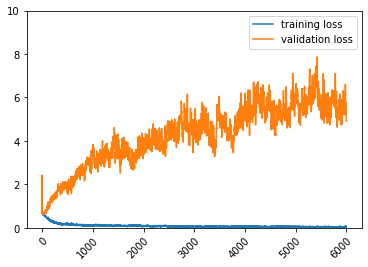

Epoch: 0000 loss_train: 0.9514 loss_val: 0.9692
Epoch: 0050 loss_train: 0.6995 loss_val: 0.6852
Epoch: 0100 loss_train: 0.5055 loss_val: 0.7123
Epoch: 0150 loss_train: 0.3473 loss_val: 0.5842
Epoch: 0200 loss_train: 0.3097 loss_val: 0.9920
Epoch: 0250 loss_train: 0.3238 loss_val: 1.2507
Epoch: 0300 loss_train: 0.2741 loss_val: 1.1340
Epoch: 0350 loss_train: 0.2231 loss_val: 1.0135
Epoch: 0400 loss_train: 0.1509 loss_val: 1.4743
Epoch: 0450 loss_train: 0.2031 loss_val: 0.7764
Epoch: 0500 loss_train: 0.1401 loss_val: 1.0684
Epoch: 0550 loss_train: 0.1898 loss_val: 1.4534
Epoch: 0600 loss_train: 0.1736 loss_val: 0.9515
Epoch: 0650 loss_train: 0.1741 loss_val: 1.1681
Epoch: 0700 loss_train: 0.1480 loss_val: 1.0854
Epoch: 0750 loss_train: 0.1413 loss_val: 1.2836
Epoch: 0800 loss_train: 0.1288 loss_val: 1.3444
Epoch: 0850 loss_train: 0.1732 loss_val: 1.2879
Epoch: 0900 loss_train: 0.1001 loss_val: 1.2358
Epoch: 0950 loss_train: 0.1384 loss_val: 1.0960
Epoch: 1000 loss_train: 0.1008 loss_val:

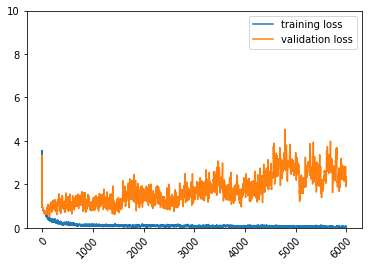

Epoch: 0000 loss_train: 0.8654 loss_val: 0.9081
Epoch: 0050 loss_train: 0.6280 loss_val: 1.0211
Epoch: 0100 loss_train: 0.5094 loss_val: 1.3448
Epoch: 0150 loss_train: 0.3979 loss_val: 1.5855
Epoch: 0200 loss_train: 0.3373 loss_val: 1.8481
Epoch: 0250 loss_train: 0.3181 loss_val: 1.8124
Epoch: 0300 loss_train: 0.2249 loss_val: 1.9338
Epoch: 0350 loss_train: 0.2667 loss_val: 2.0377
Epoch: 0400 loss_train: 0.2100 loss_val: 2.1561
Epoch: 0450 loss_train: 0.2064 loss_val: 2.2120
Epoch: 0500 loss_train: 0.1641 loss_val: 2.6289
Epoch: 0550 loss_train: 0.1710 loss_val: 2.6037
Epoch: 0600 loss_train: 0.1324 loss_val: 2.8582
Epoch: 0650 loss_train: 0.2521 loss_val: 2.7463
Epoch: 0700 loss_train: 0.1405 loss_val: 3.5332
Epoch: 0750 loss_train: 0.1036 loss_val: 3.3381
Epoch: 0800 loss_train: 0.1677 loss_val: 2.8157
Epoch: 0850 loss_train: 0.1307 loss_val: 2.7944
Epoch: 0900 loss_train: 0.1497 loss_val: 3.0902
Epoch: 0950 loss_train: 0.0907 loss_val: 3.4310
Epoch: 1000 loss_train: 0.1108 loss_val:

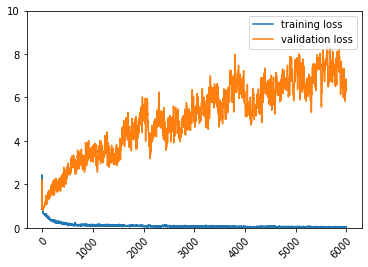

Epoch: 0000 loss_train: 0.9192 loss_val: 0.8840
Epoch: 0050 loss_train: 0.7496 loss_val: 0.7465
Epoch: 0100 loss_train: 0.6316 loss_val: 0.7086
Epoch: 0150 loss_train: 0.4436 loss_val: 0.7057
Epoch: 0200 loss_train: 0.3943 loss_val: 0.7493
Epoch: 0250 loss_train: 0.3466 loss_val: 0.8616
Epoch: 0300 loss_train: 0.2842 loss_val: 0.8947
Epoch: 0350 loss_train: 0.3153 loss_val: 1.0079
Epoch: 0400 loss_train: 0.2265 loss_val: 1.2409
Epoch: 0450 loss_train: 0.3074 loss_val: 1.2896
Epoch: 0500 loss_train: 0.2205 loss_val: 1.2456
Epoch: 0550 loss_train: 0.2296 loss_val: 1.5658
Epoch: 0600 loss_train: 0.2062 loss_val: 1.7372
Epoch: 0650 loss_train: 0.1826 loss_val: 1.3529
Epoch: 0700 loss_train: 0.1504 loss_val: 1.6737
Epoch: 0750 loss_train: 0.1556 loss_val: 1.6040
Epoch: 0800 loss_train: 0.1350 loss_val: 1.4991
Epoch: 0850 loss_train: 0.1536 loss_val: 1.4942
Epoch: 0900 loss_train: 0.1214 loss_val: 1.5389
Epoch: 0950 loss_train: 0.1212 loss_val: 1.5223
Epoch: 1000 loss_train: 0.1228 loss_val:

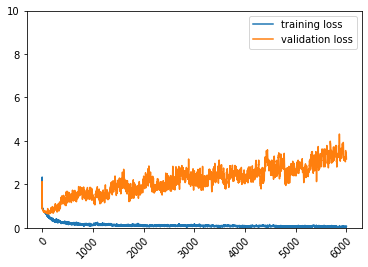

Epoch: 0000 loss_train: 1.1215 loss_val: 1.1605
Epoch: 0050 loss_train: 0.9588 loss_val: 1.1814
Epoch: 0100 loss_train: 0.7433 loss_val: 1.5407
Epoch: 0150 loss_train: 0.6677 loss_val: 2.0253
Epoch: 0200 loss_train: 0.5872 loss_val: 2.4899
Epoch: 0250 loss_train: 0.4951 loss_val: 2.9131
Epoch: 0300 loss_train: 0.4704 loss_val: 3.3848
Epoch: 0350 loss_train: 0.4514 loss_val: 3.7139
Epoch: 0400 loss_train: 0.4174 loss_val: 3.2567
Epoch: 0450 loss_train: 0.4339 loss_val: 3.9167
Epoch: 0500 loss_train: 0.3763 loss_val: 4.1992
Epoch: 0550 loss_train: 0.3508 loss_val: 3.6959
Epoch: 0600 loss_train: 0.3946 loss_val: 3.9825
Epoch: 0650 loss_train: 0.3567 loss_val: 4.4433
Epoch: 0700 loss_train: 0.3119 loss_val: 4.9108
Epoch: 0750 loss_train: 0.3130 loss_val: 4.1479
Epoch: 0800 loss_train: 0.3316 loss_val: 4.6207
Epoch: 0850 loss_train: 0.2713 loss_val: 5.8330
Epoch: 0900 loss_train: 0.2958 loss_val: 4.8167
Epoch: 0950 loss_train: 0.2882 loss_val: 6.0075
Epoch: 1000 loss_train: 0.2901 loss_val:

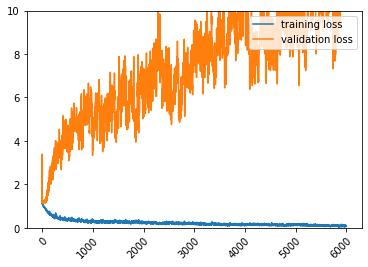

Epoch: 0000 loss_train: 0.9923 loss_val: 1.0098
Epoch: 0050 loss_train: 0.7863 loss_val: 0.8253
Epoch: 0100 loss_train: 0.6794 loss_val: 0.8704
Epoch: 0150 loss_train: 0.6373 loss_val: 0.9271
Epoch: 0200 loss_train: 0.5837 loss_val: 0.8830
Epoch: 0250 loss_train: 0.5249 loss_val: 0.9510
Epoch: 0300 loss_train: 0.4298 loss_val: 1.0769
Epoch: 0350 loss_train: 0.4372 loss_val: 1.0959
Epoch: 0400 loss_train: 0.3885 loss_val: 1.3029
Epoch: 0450 loss_train: 0.3729 loss_val: 1.3936
Epoch: 0500 loss_train: 0.3402 loss_val: 1.5429
Epoch: 0550 loss_train: 0.3136 loss_val: 1.6486
Epoch: 0600 loss_train: 0.3040 loss_val: 1.6767
Epoch: 0650 loss_train: 0.2934 loss_val: 1.6451
Epoch: 0700 loss_train: 0.2797 loss_val: 1.9165
Epoch: 0750 loss_train: 0.2339 loss_val: 2.2100
Epoch: 0800 loss_train: 0.2590 loss_val: 2.0171
Epoch: 0850 loss_train: 0.2631 loss_val: 2.0631
Epoch: 0900 loss_train: 0.2293 loss_val: 2.2393
Epoch: 0950 loss_train: 0.2273 loss_val: 2.1308
Epoch: 1000 loss_train: 0.1875 loss_val:

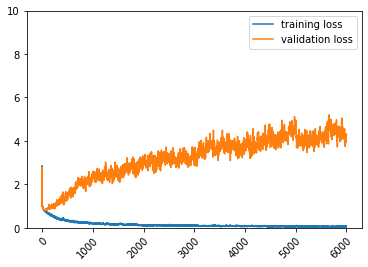

Epoch: 0000 loss_train: 1.0603 loss_val: 1.1041
Epoch: 0050 loss_train: 0.8271 loss_val: 1.0447
Epoch: 0100 loss_train: 0.7284 loss_val: 1.2137
Epoch: 0150 loss_train: 0.4435 loss_val: 1.5535
Epoch: 0200 loss_train: 0.4024 loss_val: 1.7378
Epoch: 0250 loss_train: 0.3298 loss_val: 2.1609
Epoch: 0300 loss_train: 0.3587 loss_val: 1.8978
Epoch: 0350 loss_train: 0.2893 loss_val: 2.6462
Epoch: 0400 loss_train: 0.2853 loss_val: 2.4025
Epoch: 0450 loss_train: 0.3060 loss_val: 2.6167
Epoch: 0500 loss_train: 0.3131 loss_val: 3.3354
Epoch: 0550 loss_train: 0.2285 loss_val: 3.1805
Epoch: 0600 loss_train: 0.2149 loss_val: 3.2432
Epoch: 0650 loss_train: 0.2605 loss_val: 3.8486
Epoch: 0700 loss_train: 0.1867 loss_val: 4.4354
Epoch: 0750 loss_train: 0.2535 loss_val: 4.1097
Epoch: 0800 loss_train: 0.2230 loss_val: 4.0206
Epoch: 0850 loss_train: 0.2261 loss_val: 3.5006
Epoch: 0900 loss_train: 0.1491 loss_val: 3.6602
Epoch: 0950 loss_train: 0.1678 loss_val: 4.3728
Epoch: 1000 loss_train: 0.1876 loss_val:

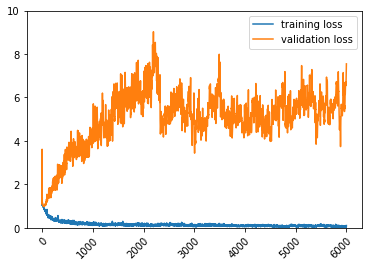

Epoch: 0000 loss_train: 1.0106 loss_val: 1.0505
Epoch: 0050 loss_train: 0.7870 loss_val: 1.0018
Epoch: 0100 loss_train: 0.6380 loss_val: 1.3880
Epoch: 0150 loss_train: 0.5344 loss_val: 1.9935
Epoch: 0200 loss_train: 0.4303 loss_val: 2.6750
Epoch: 0250 loss_train: 0.3786 loss_val: 2.4458
Epoch: 0300 loss_train: 0.3838 loss_val: 3.1779
Epoch: 0350 loss_train: 0.3031 loss_val: 2.7830
Epoch: 0400 loss_train: 0.2759 loss_val: 3.0712
Epoch: 0450 loss_train: 0.2649 loss_val: 3.4502
Epoch: 0500 loss_train: 0.2336 loss_val: 3.3740
Epoch: 0550 loss_train: 0.2324 loss_val: 4.4760
Epoch: 0600 loss_train: 0.2426 loss_val: 4.2923
Epoch: 0650 loss_train: 0.1713 loss_val: 4.3830
Epoch: 0700 loss_train: 0.1773 loss_val: 6.7380
Epoch: 0750 loss_train: 0.2062 loss_val: 5.4568
Epoch: 0800 loss_train: 0.2120 loss_val: 4.6267
Epoch: 0850 loss_train: 0.2171 loss_val: 4.5660
Epoch: 0900 loss_train: 0.1765 loss_val: 5.1827
Epoch: 0950 loss_train: 0.1835 loss_val: 6.4759
Epoch: 1000 loss_train: 0.1796 loss_val:

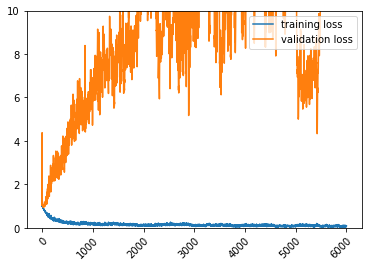

Epoch: 0000 loss_train: 1.0629 loss_val: 1.0615
Epoch: 0050 loss_train: 0.8868 loss_val: 0.8741
Epoch: 0100 loss_train: 0.7394 loss_val: 0.8989
Epoch: 0150 loss_train: 0.6560 loss_val: 1.1688
Epoch: 0200 loss_train: 0.6248 loss_val: 1.3302
Epoch: 0250 loss_train: 0.5382 loss_val: 1.6400
Epoch: 0300 loss_train: 0.4658 loss_val: 1.3388
Epoch: 0350 loss_train: 0.5546 loss_val: 1.6521
Epoch: 0400 loss_train: 0.4696 loss_val: 1.7792
Epoch: 0450 loss_train: 0.4070 loss_val: 2.0126
Epoch: 0500 loss_train: 0.4471 loss_val: 2.0203
Epoch: 0550 loss_train: 0.3953 loss_val: 2.3738
Epoch: 0600 loss_train: 0.3644 loss_val: 2.7036
Epoch: 0650 loss_train: 0.3741 loss_val: 2.9293
Epoch: 0700 loss_train: 0.2869 loss_val: 3.3433
Epoch: 0750 loss_train: 0.3364 loss_val: 3.0018
Epoch: 0800 loss_train: 0.2951 loss_val: 3.3643
Epoch: 0850 loss_train: 0.2975 loss_val: 3.4055
Epoch: 0900 loss_train: 0.2742 loss_val: 3.8155
Epoch: 0950 loss_train: 0.3074 loss_val: 3.5123
Epoch: 1000 loss_train: 0.3271 loss_val:

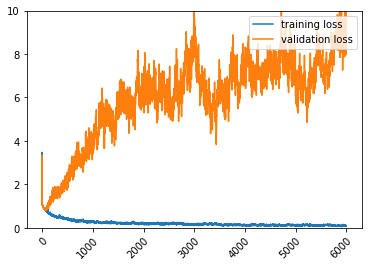

Epoch: 0000 loss_train: 0.9479 loss_val: 0.9519
Epoch: 0050 loss_train: 0.7338 loss_val: 0.9434
Epoch: 0100 loss_train: 0.5614 loss_val: 1.0564
Epoch: 0150 loss_train: 0.4567 loss_val: 1.5626
Epoch: 0200 loss_train: 0.4271 loss_val: 1.7749
Epoch: 0250 loss_train: 0.3377 loss_val: 2.0117
Epoch: 0300 loss_train: 0.2940 loss_val: 2.0935
Epoch: 0350 loss_train: 0.2608 loss_val: 2.5687
Epoch: 0400 loss_train: 0.3031 loss_val: 2.7780
Epoch: 0450 loss_train: 0.2180 loss_val: 3.2788
Epoch: 0500 loss_train: 0.2211 loss_val: 3.1751
Epoch: 0550 loss_train: 0.2351 loss_val: 2.9364
Epoch: 0600 loss_train: 0.2339 loss_val: 4.0556
Epoch: 0650 loss_train: 0.2466 loss_val: 3.8490
Epoch: 0700 loss_train: 0.1713 loss_val: 4.5476
Epoch: 0750 loss_train: 0.1731 loss_val: 4.4131
Epoch: 0800 loss_train: 0.1721 loss_val: 3.9501
Epoch: 0850 loss_train: 0.1741 loss_val: 4.7031
Epoch: 0900 loss_train: 0.1468 loss_val: 4.4402
Epoch: 0950 loss_train: 0.1472 loss_val: 4.5619
Epoch: 1000 loss_train: 0.1310 loss_val:

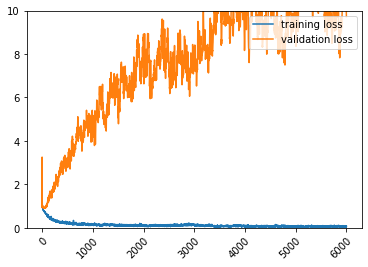

Epoch: 0000 loss_train: 0.9012 loss_val: 0.9664
Epoch: 0050 loss_train: 0.6913 loss_val: 0.8511
Epoch: 0100 loss_train: 0.5404 loss_val: 1.3843
Epoch: 0150 loss_train: 0.4313 loss_val: 1.7193
Epoch: 0200 loss_train: 0.3743 loss_val: 2.9151
Epoch: 0250 loss_train: 0.3570 loss_val: 2.1937
Epoch: 0300 loss_train: 0.2930 loss_val: 2.4715
Epoch: 0350 loss_train: 0.2936 loss_val: 3.0171
Epoch: 0400 loss_train: 0.2358 loss_val: 3.3676
Epoch: 0450 loss_train: 0.2757 loss_val: 3.2135
Epoch: 0500 loss_train: 0.2020 loss_val: 3.9100
Epoch: 0550 loss_train: 0.2669 loss_val: 3.5913
Epoch: 0600 loss_train: 0.2449 loss_val: 4.4703
Epoch: 0650 loss_train: 0.1929 loss_val: 5.1342
Epoch: 0700 loss_train: 0.2483 loss_val: 4.9814
Epoch: 0750 loss_train: 0.1968 loss_val: 4.7916
Epoch: 0800 loss_train: 0.1963 loss_val: 4.4409
Epoch: 0850 loss_train: 0.2357 loss_val: 4.4251
Epoch: 0900 loss_train: 0.1972 loss_val: 4.9510
Epoch: 0950 loss_train: 0.1519 loss_val: 6.0820
Epoch: 1000 loss_train: 0.1790 loss_val:

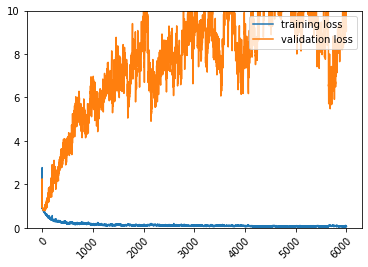

Epoch: 0000 loss_train: 0.7943 loss_val: 0.7916
Epoch: 0050 loss_train: 0.6691 loss_val: 0.7332
Epoch: 0100 loss_train: 0.5464 loss_val: 0.8385
Epoch: 0150 loss_train: 0.4178 loss_val: 0.8630
Epoch: 0200 loss_train: 0.3347 loss_val: 1.3346
Epoch: 0250 loss_train: 0.2932 loss_val: 1.3472
Epoch: 0300 loss_train: 0.2514 loss_val: 1.5137
Epoch: 0350 loss_train: 0.2278 loss_val: 1.7177
Epoch: 0400 loss_train: 0.2186 loss_val: 1.8039
Epoch: 0450 loss_train: 0.2103 loss_val: 1.8826
Epoch: 0500 loss_train: 0.1461 loss_val: 2.0324
Epoch: 0550 loss_train: 0.1281 loss_val: 1.9701
Epoch: 0600 loss_train: 0.1578 loss_val: 2.0156
Epoch: 0650 loss_train: 0.1394 loss_val: 2.1777
Epoch: 0700 loss_train: 0.1940 loss_val: 1.7605
Epoch: 0750 loss_train: 0.1123 loss_val: 1.9458
Epoch: 0800 loss_train: 0.1497 loss_val: 2.2183
Epoch: 0850 loss_train: 0.1339 loss_val: 2.2600
Epoch: 0900 loss_train: 0.1351 loss_val: 2.1589
Epoch: 0950 loss_train: 0.1440 loss_val: 2.2551
Epoch: 1000 loss_train: 0.1165 loss_val:

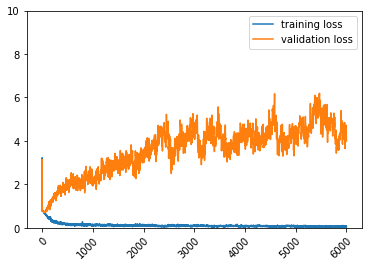

Epoch: 0000 loss_train: 0.6617 loss_val: 0.6658
Epoch: 0050 loss_train: 0.5817 loss_val: 0.5844
Epoch: 0100 loss_train: 0.5042 loss_val: 0.6789
Epoch: 0150 loss_train: 0.4024 loss_val: 0.8164
Epoch: 0200 loss_train: 0.3508 loss_val: 0.8450
Epoch: 0250 loss_train: 0.3073 loss_val: 1.0547
Epoch: 0300 loss_train: 0.2694 loss_val: 1.1888
Epoch: 0350 loss_train: 0.3128 loss_val: 1.1009
Epoch: 0400 loss_train: 0.2175 loss_val: 1.2474
Epoch: 0450 loss_train: 0.2218 loss_val: 1.3873
Epoch: 0500 loss_train: 0.1854 loss_val: 1.6059
Epoch: 0550 loss_train: 0.2217 loss_val: 1.6219
Epoch: 0600 loss_train: 0.2173 loss_val: 1.5971
Epoch: 0650 loss_train: 0.1743 loss_val: 1.6562
Epoch: 0700 loss_train: 0.1997 loss_val: 1.4997
Epoch: 0750 loss_train: 0.1523 loss_val: 1.7372
Epoch: 0800 loss_train: 0.1329 loss_val: 1.9159
Epoch: 0850 loss_train: 0.1705 loss_val: 1.8944
Epoch: 0900 loss_train: 0.1504 loss_val: 1.7632
Epoch: 0950 loss_train: 0.1371 loss_val: 1.8370
Epoch: 1000 loss_train: 0.1311 loss_val:

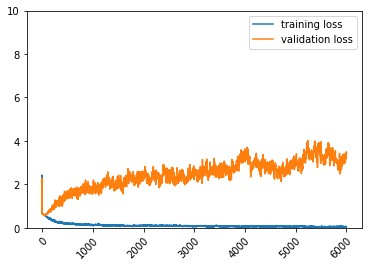

Epoch: 0000 loss_train: 0.7351 loss_val: 0.7229
Epoch: 0050 loss_train: 0.5606 loss_val: 0.5707
Epoch: 0100 loss_train: 0.4547 loss_val: 0.6508
Epoch: 0150 loss_train: 0.3838 loss_val: 0.5525
Epoch: 0200 loss_train: 0.2712 loss_val: 0.7364
Epoch: 0250 loss_train: 0.2793 loss_val: 0.7298
Epoch: 0300 loss_train: 0.2122 loss_val: 0.8132
Epoch: 0350 loss_train: 0.1965 loss_val: 0.9908
Epoch: 0400 loss_train: 0.2162 loss_val: 1.0916
Epoch: 0450 loss_train: 0.1812 loss_val: 0.9939
Epoch: 0500 loss_train: 0.1746 loss_val: 1.1505
Epoch: 0550 loss_train: 0.1492 loss_val: 1.2284
Epoch: 0600 loss_train: 0.1242 loss_val: 1.2599
Epoch: 0650 loss_train: 0.1338 loss_val: 1.0992
Epoch: 0700 loss_train: 0.1006 loss_val: 1.0590
Epoch: 0750 loss_train: 0.1219 loss_val: 1.3661
Epoch: 0800 loss_train: 0.1405 loss_val: 1.2590
Epoch: 0850 loss_train: 0.1351 loss_val: 1.4432
Epoch: 0900 loss_train: 0.1179 loss_val: 1.2494
Epoch: 0950 loss_train: 0.1073 loss_val: 1.4260
Epoch: 1000 loss_train: 0.1060 loss_val:

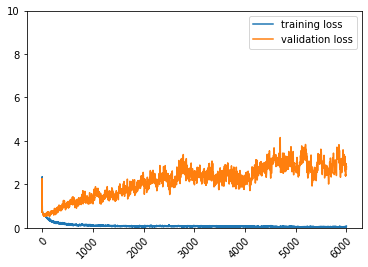

Epoch: 0000 loss_train: 0.8830 loss_val: 0.9055
Epoch: 0050 loss_train: 0.6948 loss_val: 1.0983
Epoch: 0100 loss_train: 0.5790 loss_val: 1.0174
Epoch: 0150 loss_train: 0.4826 loss_val: 1.3649
Epoch: 0200 loss_train: 0.3953 loss_val: 1.6939
Epoch: 0250 loss_train: 0.2992 loss_val: 1.8957
Epoch: 0300 loss_train: 0.2926 loss_val: 1.9747
Epoch: 0350 loss_train: 0.2525 loss_val: 2.1472
Epoch: 0400 loss_train: 0.1981 loss_val: 2.5093
Epoch: 0450 loss_train: 0.2254 loss_val: 2.3764
Epoch: 0500 loss_train: 0.1959 loss_val: 3.1409
Epoch: 0550 loss_train: 0.1970 loss_val: 3.0320
Epoch: 0600 loss_train: 0.1636 loss_val: 3.1349
Epoch: 0650 loss_train: 0.1445 loss_val: 3.7109
Epoch: 0700 loss_train: 0.1707 loss_val: 3.1024
Epoch: 0750 loss_train: 0.1109 loss_val: 3.1599
Epoch: 0800 loss_train: 0.1582 loss_val: 3.6761
Epoch: 0850 loss_train: 0.1538 loss_val: 3.7297
Epoch: 0900 loss_train: 0.1577 loss_val: 3.6461
Epoch: 0950 loss_train: 0.1963 loss_val: 3.8654
Epoch: 1000 loss_train: 0.1447 loss_val:

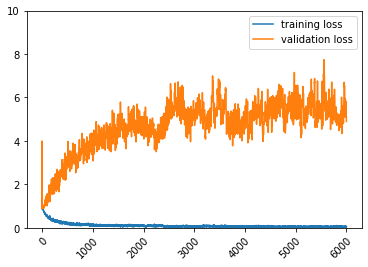

Epoch: 0000 loss_train: 0.9999 loss_val: 0.9943
Epoch: 0050 loss_train: 0.7933 loss_val: 0.9726
Epoch: 0100 loss_train: 0.5769 loss_val: 1.6562
Epoch: 0150 loss_train: 0.4650 loss_val: 1.7772
Epoch: 0200 loss_train: 0.3378 loss_val: 2.2447
Epoch: 0250 loss_train: 0.3516 loss_val: 3.0097
Epoch: 0300 loss_train: 0.2805 loss_val: 2.4429
Epoch: 0350 loss_train: 0.2558 loss_val: 2.6581
Epoch: 0400 loss_train: 0.2606 loss_val: 2.8381
Epoch: 0450 loss_train: 0.2453 loss_val: 3.0605
Epoch: 0500 loss_train: 0.2225 loss_val: 3.1229
Epoch: 0550 loss_train: 0.2323 loss_val: 4.3875
Epoch: 0600 loss_train: 0.1938 loss_val: 4.4040
Epoch: 0650 loss_train: 0.2482 loss_val: 3.8851
Epoch: 0700 loss_train: 0.2025 loss_val: 4.7839
Epoch: 0750 loss_train: 0.1910 loss_val: 4.1523
Epoch: 0800 loss_train: 0.2069 loss_val: 3.4922
Epoch: 0850 loss_train: 0.1655 loss_val: 4.7369
Epoch: 0900 loss_train: 0.1633 loss_val: 6.0329
Epoch: 0950 loss_train: 0.2186 loss_val: 4.7012
Epoch: 1000 loss_train: 0.2150 loss_val:

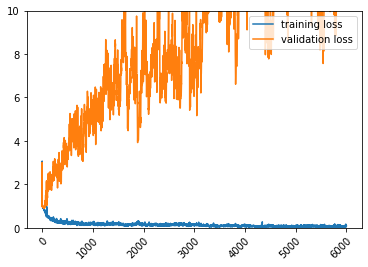

Epoch: 0000 loss_train: 1.1235 loss_val: 1.1280
Epoch: 0050 loss_train: 0.9692 loss_val: 0.9867
Epoch: 0100 loss_train: 0.7956 loss_val: 1.1100
Epoch: 0150 loss_train: 0.6985 loss_val: 1.3566
Epoch: 0200 loss_train: 0.6824 loss_val: 1.3838
Epoch: 0250 loss_train: 0.6097 loss_val: 1.6123
Epoch: 0300 loss_train: 0.5108 loss_val: 1.9349
Epoch: 0350 loss_train: 0.4846 loss_val: 1.9386
Epoch: 0400 loss_train: 0.4444 loss_val: 2.3989
Epoch: 0450 loss_train: 0.4786 loss_val: 2.5736
Epoch: 0500 loss_train: 0.3834 loss_val: 3.2202
Epoch: 0550 loss_train: 0.3812 loss_val: 3.4657
Epoch: 0600 loss_train: 0.3622 loss_val: 3.9703
Epoch: 0650 loss_train: 0.3624 loss_val: 4.2981
Epoch: 0700 loss_train: 0.3664 loss_val: 4.7879
Epoch: 0750 loss_train: 0.3606 loss_val: 4.2761
Epoch: 0800 loss_train: 0.3767 loss_val: 4.7635
Epoch: 0850 loss_train: 0.3514 loss_val: 4.8792
Epoch: 0900 loss_train: 0.2872 loss_val: 5.0792
Epoch: 0950 loss_train: 0.2843 loss_val: 4.5654
Epoch: 1000 loss_train: 0.2611 loss_val:

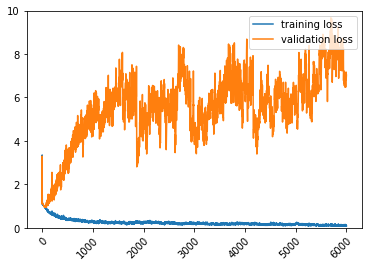

Epoch: 0000 loss_train: 1.0085 loss_val: 0.9727
Epoch: 0050 loss_train: 0.8268 loss_val: 0.7861
Epoch: 0100 loss_train: 0.7175 loss_val: 0.8403
Epoch: 0150 loss_train: 0.6055 loss_val: 1.0038
Epoch: 0200 loss_train: 0.5318 loss_val: 1.0012
Epoch: 0250 loss_train: 0.4767 loss_val: 1.2406
Epoch: 0300 loss_train: 0.4995 loss_val: 1.2484
Epoch: 0350 loss_train: 0.4623 loss_val: 1.3479
Epoch: 0400 loss_train: 0.3874 loss_val: 1.6878
Epoch: 0450 loss_train: 0.3231 loss_val: 1.8902
Epoch: 0500 loss_train: 0.3836 loss_val: 1.8229
Epoch: 0550 loss_train: 0.3327 loss_val: 1.9279
Epoch: 0600 loss_train: 0.3611 loss_val: 2.1660
Epoch: 0650 loss_train: 0.2657 loss_val: 2.2502
Epoch: 0700 loss_train: 0.2252 loss_val: 2.4530
Epoch: 0750 loss_train: 0.3352 loss_val: 2.6530
Epoch: 0800 loss_train: 0.2585 loss_val: 2.9489
Epoch: 0850 loss_train: 0.2174 loss_val: 2.9750
Epoch: 0900 loss_train: 0.2450 loss_val: 3.4183
Epoch: 0950 loss_train: 0.2130 loss_val: 3.1996
Epoch: 1000 loss_train: 0.2503 loss_val:

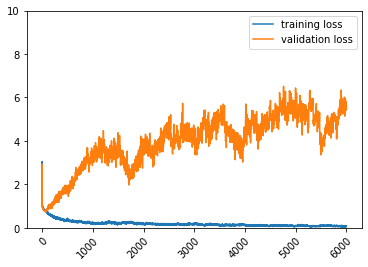

Epoch: 0000 loss_train: 1.0628 loss_val: 1.1523
Epoch: 0050 loss_train: 0.9350 loss_val: 1.1182
Epoch: 0100 loss_train: 0.8638 loss_val: 1.0861
Epoch: 0150 loss_train: 0.7790 loss_val: 1.1889
Epoch: 0200 loss_train: 0.7664 loss_val: 1.4718
Epoch: 0250 loss_train: 0.6502 loss_val: 1.7091
Epoch: 0300 loss_train: 0.6108 loss_val: 1.9047
Epoch: 0350 loss_train: 0.6259 loss_val: 1.8179
Epoch: 0400 loss_train: 0.5883 loss_val: 2.2255
Epoch: 0450 loss_train: 0.6009 loss_val: 2.7658
Epoch: 0500 loss_train: 0.5428 loss_val: 2.9840
Epoch: 0550 loss_train: 0.4993 loss_val: 2.8482
Epoch: 0600 loss_train: 0.5031 loss_val: 3.1965
Epoch: 0650 loss_train: 0.5039 loss_val: 3.2521
Epoch: 0700 loss_train: 0.4375 loss_val: 3.7623
Epoch: 0750 loss_train: 0.4269 loss_val: 4.1568
Epoch: 0800 loss_train: 0.5234 loss_val: 3.0110
Epoch: 0850 loss_train: 0.4323 loss_val: 4.4135
Epoch: 0900 loss_train: 0.4566 loss_val: 4.5981
Epoch: 0950 loss_train: 0.4648 loss_val: 3.4158
Epoch: 1000 loss_train: 0.4308 loss_val:

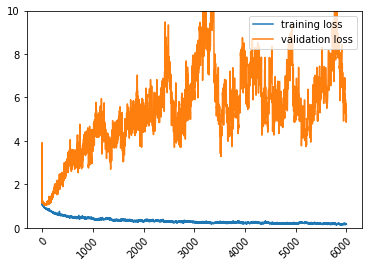

Epoch: 0000 loss_train: 1.0197 loss_val: 1.0739
Epoch: 0050 loss_train: 0.8121 loss_val: 0.8797
Epoch: 0100 loss_train: 0.7426 loss_val: 0.8671
Epoch: 0150 loss_train: 0.6611 loss_val: 0.8847
Epoch: 0200 loss_train: 0.5795 loss_val: 1.1120
Epoch: 0250 loss_train: 0.5410 loss_val: 1.1647
Epoch: 0300 loss_train: 0.5006 loss_val: 1.5618
Epoch: 0350 loss_train: 0.5333 loss_val: 1.2074
Epoch: 0400 loss_train: 0.4453 loss_val: 1.4474
Epoch: 0450 loss_train: 0.4409 loss_val: 1.4470
Epoch: 0500 loss_train: 0.4276 loss_val: 1.5903
Epoch: 0550 loss_train: 0.3945 loss_val: 1.8952
Epoch: 0600 loss_train: 0.4000 loss_val: 1.7817
Epoch: 0650 loss_train: 0.3889 loss_val: 1.7964
Epoch: 0700 loss_train: 0.3483 loss_val: 1.9385
Epoch: 0750 loss_train: 0.3142 loss_val: 1.9990
Epoch: 0800 loss_train: 0.3434 loss_val: 2.1792
Epoch: 0850 loss_train: 0.3364 loss_val: 2.0825
Epoch: 0900 loss_train: 0.3021 loss_val: 2.2804
Epoch: 0950 loss_train: 0.2931 loss_val: 2.6592
Epoch: 1000 loss_train: 0.2947 loss_val:

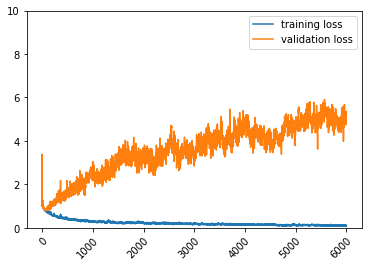

Epoch: 0000 loss_train: 1.1105 loss_val: 1.1972
Epoch: 0050 loss_train: 0.8938 loss_val: 1.0145
Epoch: 0100 loss_train: 0.7738 loss_val: 1.3521
Epoch: 0150 loss_train: 0.6741 loss_val: 1.6502
Epoch: 0200 loss_train: 0.5784 loss_val: 1.7184
Epoch: 0250 loss_train: 0.5611 loss_val: 2.2357
Epoch: 0300 loss_train: 0.4166 loss_val: 2.4481
Epoch: 0350 loss_train: 0.4737 loss_val: 2.3267
Epoch: 0400 loss_train: 0.4089 loss_val: 3.2084
Epoch: 0450 loss_train: 0.3604 loss_val: 3.2842
Epoch: 0500 loss_train: 0.4167 loss_val: 2.7653
Epoch: 0550 loss_train: 0.3126 loss_val: 3.7976
Epoch: 0600 loss_train: 0.3307 loss_val: 3.9326
Epoch: 0650 loss_train: 0.3268 loss_val: 4.1614
Epoch: 0700 loss_train: 0.2888 loss_val: 4.5041
Epoch: 0750 loss_train: 0.2859 loss_val: 4.5645
Epoch: 0800 loss_train: 0.2892 loss_val: 4.0392
Epoch: 0850 loss_train: 0.2297 loss_val: 4.8302
Epoch: 0900 loss_train: 0.3680 loss_val: 3.5919
Epoch: 0950 loss_train: 0.2633 loss_val: 3.9196
Epoch: 1000 loss_train: 0.2639 loss_val:

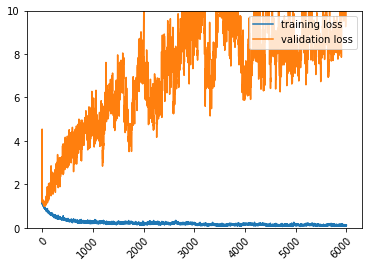

Epoch: 0000 loss_train: 1.0182 loss_val: 0.9715
Epoch: 0050 loss_train: 0.8294 loss_val: 0.7065
Epoch: 0100 loss_train: 0.7289 loss_val: 0.7146
Epoch: 0150 loss_train: 0.6446 loss_val: 0.8086
Epoch: 0200 loss_train: 0.6548 loss_val: 0.7974
Epoch: 0250 loss_train: 0.5190 loss_val: 0.8181
Epoch: 0300 loss_train: 0.4955 loss_val: 0.8584
Epoch: 0350 loss_train: 0.4448 loss_val: 0.8609
Epoch: 0400 loss_train: 0.4109 loss_val: 0.9138
Epoch: 0450 loss_train: 0.4354 loss_val: 0.9797
Epoch: 0500 loss_train: 0.3849 loss_val: 1.0033
Epoch: 0550 loss_train: 0.4095 loss_val: 1.0122
Epoch: 0600 loss_train: 0.3404 loss_val: 1.2315
Epoch: 0650 loss_train: 0.3259 loss_val: 1.3574
Epoch: 0700 loss_train: 0.3240 loss_val: 1.3003
Epoch: 0750 loss_train: 0.3116 loss_val: 1.3393
Epoch: 0800 loss_train: 0.2988 loss_val: 1.4912
Epoch: 0850 loss_train: 0.3039 loss_val: 1.3490
Epoch: 0900 loss_train: 0.2977 loss_val: 1.5809
Epoch: 0950 loss_train: 0.2696 loss_val: 1.5844
Epoch: 1000 loss_train: 0.2403 loss_val:

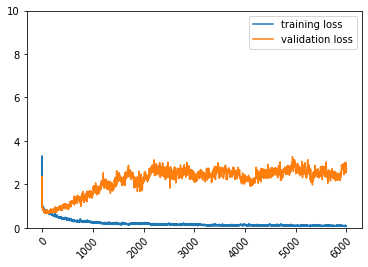

Epoch: 0000 loss_train: 0.5659 loss_val: 0.6644
Epoch: 0050 loss_train: 0.4171 loss_val: 0.6587
Epoch: 0100 loss_train: 0.3215 loss_val: 0.7791
Epoch: 0150 loss_train: 0.2430 loss_val: 1.0990
Epoch: 0200 loss_train: 0.2480 loss_val: 0.9047
Epoch: 0250 loss_train: 0.2173 loss_val: 1.1653
Epoch: 0300 loss_train: 0.1677 loss_val: 1.5776
Epoch: 0350 loss_train: 0.1884 loss_val: 1.7254
Epoch: 0400 loss_train: 0.1419 loss_val: 1.6049
Epoch: 0450 loss_train: 0.1370 loss_val: 1.7267
Epoch: 0500 loss_train: 0.1312 loss_val: 1.7886
Epoch: 0550 loss_train: 0.1526 loss_val: 1.6362
Epoch: 0600 loss_train: 0.1311 loss_val: 1.8476
Epoch: 0650 loss_train: 0.1226 loss_val: 2.1185
Epoch: 0700 loss_train: 0.1234 loss_val: 2.0919
Epoch: 0750 loss_train: 0.1046 loss_val: 2.3864
Epoch: 0800 loss_train: 0.1060 loss_val: 2.3309
Epoch: 0850 loss_train: 0.0912 loss_val: 2.5187
Epoch: 0900 loss_train: 0.1019 loss_val: 2.5143
Epoch: 0950 loss_train: 0.1255 loss_val: 2.9123
Epoch: 1000 loss_train: 0.1294 loss_val:

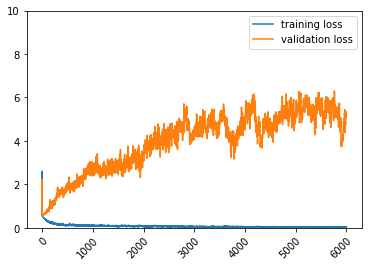

Epoch: 0000 loss_train: 0.7028 loss_val: 0.7074
Epoch: 0050 loss_train: 0.5637 loss_val: 0.6003
Epoch: 0100 loss_train: 0.4559 loss_val: 0.6477
Epoch: 0150 loss_train: 0.3816 loss_val: 0.8324
Epoch: 0200 loss_train: 0.3234 loss_val: 0.9322
Epoch: 0250 loss_train: 0.2573 loss_val: 1.0613
Epoch: 0300 loss_train: 0.2378 loss_val: 1.0877
Epoch: 0350 loss_train: 0.2300 loss_val: 1.1381
Epoch: 0400 loss_train: 0.1837 loss_val: 1.3128
Epoch: 0450 loss_train: 0.1928 loss_val: 1.5434
Epoch: 0500 loss_train: 0.1835 loss_val: 1.2979
Epoch: 0550 loss_train: 0.1209 loss_val: 1.5829
Epoch: 0600 loss_train: 0.1339 loss_val: 1.4406
Epoch: 0650 loss_train: 0.1700 loss_val: 1.2379
Epoch: 0700 loss_train: 0.1445 loss_val: 1.6478
Epoch: 0750 loss_train: 0.1373 loss_val: 1.4136
Epoch: 0800 loss_train: 0.1179 loss_val: 1.4837
Epoch: 0850 loss_train: 0.1247 loss_val: 1.7819
Epoch: 0900 loss_train: 0.1153 loss_val: 1.8636
Epoch: 0950 loss_train: 0.1287 loss_val: 1.6872
Epoch: 1000 loss_train: 0.1122 loss_val:

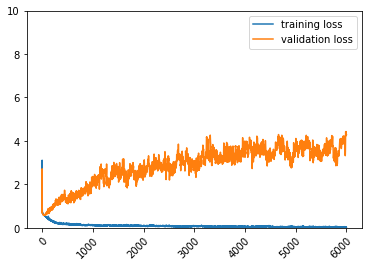

Epoch: 0000 loss_train: 0.6144 loss_val: 0.5675
Epoch: 0050 loss_train: 0.5207 loss_val: 0.5998
Epoch: 0100 loss_train: 0.4547 loss_val: 0.6792
Epoch: 0150 loss_train: 0.3089 loss_val: 0.9292
Epoch: 0200 loss_train: 0.2894 loss_val: 1.1595
Epoch: 0250 loss_train: 0.2972 loss_val: 1.0762
Epoch: 0300 loss_train: 0.2253 loss_val: 1.3124
Epoch: 0350 loss_train: 0.1993 loss_val: 1.4438
Epoch: 0400 loss_train: 0.1725 loss_val: 1.4540
Epoch: 0450 loss_train: 0.1823 loss_val: 1.8860
Epoch: 0500 loss_train: 0.1743 loss_val: 1.9974
Epoch: 0550 loss_train: 0.1481 loss_val: 2.1632
Epoch: 0600 loss_train: 0.1520 loss_val: 1.9757
Epoch: 0650 loss_train: 0.1450 loss_val: 2.3054
Epoch: 0700 loss_train: 0.1278 loss_val: 2.1720
Epoch: 0750 loss_train: 0.1355 loss_val: 2.6696
Epoch: 0800 loss_train: 0.1835 loss_val: 2.7677
Epoch: 0850 loss_train: 0.1021 loss_val: 2.7460
Epoch: 0900 loss_train: 0.1100 loss_val: 2.8483
Epoch: 0950 loss_train: 0.1311 loss_val: 3.0942
Epoch: 1000 loss_train: 0.1177 loss_val:

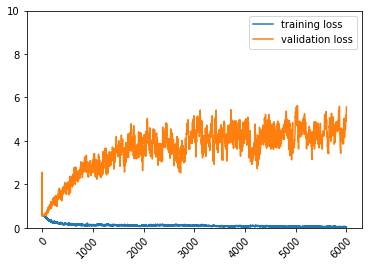

Epoch: 0000 loss_train: 0.6627 loss_val: 0.6626
Epoch: 0050 loss_train: 0.5695 loss_val: 0.6277
Epoch: 0100 loss_train: 0.4748 loss_val: 0.7058
Epoch: 0150 loss_train: 0.4118 loss_val: 0.7713
Epoch: 0200 loss_train: 0.3421 loss_val: 0.9526
Epoch: 0250 loss_train: 0.3103 loss_val: 0.9856
Epoch: 0300 loss_train: 0.2910 loss_val: 1.1146
Epoch: 0350 loss_train: 0.2722 loss_val: 1.2595
Epoch: 0400 loss_train: 0.2305 loss_val: 1.3516
Epoch: 0450 loss_train: 0.1997 loss_val: 1.9448
Epoch: 0500 loss_train: 0.2250 loss_val: 1.7318
Epoch: 0550 loss_train: 0.1982 loss_val: 1.7455
Epoch: 0600 loss_train: 0.1693 loss_val: 2.0444
Epoch: 0650 loss_train: 0.1724 loss_val: 2.1071
Epoch: 0700 loss_train: 0.1662 loss_val: 2.1883
Epoch: 0750 loss_train: 0.1533 loss_val: 1.9791
Epoch: 0800 loss_train: 0.1528 loss_val: 1.9921
Epoch: 0850 loss_train: 0.1447 loss_val: 2.2322
Epoch: 0900 loss_train: 0.1512 loss_val: 2.0952
Epoch: 0950 loss_train: 0.1551 loss_val: 2.0121
Epoch: 1000 loss_train: 0.1280 loss_val:

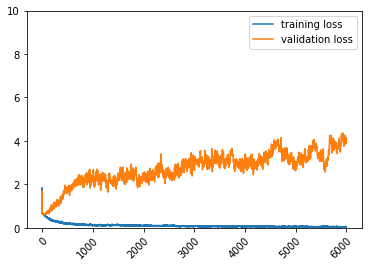

Epoch: 0000 loss_train: 0.7955 loss_val: 0.7957
Epoch: 0050 loss_train: 0.6228 loss_val: 0.8053
Epoch: 0100 loss_train: 0.5094 loss_val: 0.8101
Epoch: 0150 loss_train: 0.3860 loss_val: 0.9814
Epoch: 0200 loss_train: 0.3311 loss_val: 1.5041
Epoch: 0250 loss_train: 0.2475 loss_val: 1.8022
Epoch: 0300 loss_train: 0.1852 loss_val: 1.5096
Epoch: 0350 loss_train: 0.2412 loss_val: 1.7977
Epoch: 0400 loss_train: 0.1936 loss_val: 1.8241
Epoch: 0450 loss_train: 0.1415 loss_val: 1.9608
Epoch: 0500 loss_train: 0.1535 loss_val: 2.3410
Epoch: 0550 loss_train: 0.1260 loss_val: 2.4061
Epoch: 0600 loss_train: 0.1392 loss_val: 2.1721
Epoch: 0650 loss_train: 0.1644 loss_val: 2.1000
Epoch: 0700 loss_train: 0.1385 loss_val: 2.8088
Epoch: 0750 loss_train: 0.1274 loss_val: 2.3408
Epoch: 0800 loss_train: 0.1162 loss_val: 2.5658
Epoch: 0850 loss_train: 0.1484 loss_val: 2.7803
Epoch: 0900 loss_train: 0.1020 loss_val: 2.8508
Epoch: 0950 loss_train: 0.1075 loss_val: 2.8866
Epoch: 1000 loss_train: 0.1492 loss_val:

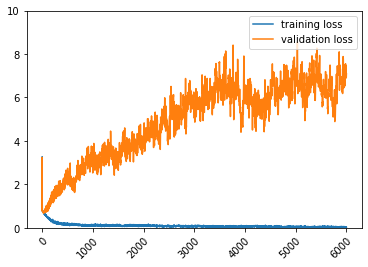

Epoch: 0000 loss_train: 0.6567 loss_val: 0.6597
Epoch: 0050 loss_train: 0.5891 loss_val: 0.5571
Epoch: 0100 loss_train: 0.5061 loss_val: 0.5986
Epoch: 0150 loss_train: 0.4293 loss_val: 0.8912
Epoch: 0200 loss_train: 0.3659 loss_val: 1.1591
Epoch: 0250 loss_train: 0.3454 loss_val: 1.3609
Epoch: 0300 loss_train: 0.3122 loss_val: 1.6439
Epoch: 0350 loss_train: 0.2676 loss_val: 1.8047
Epoch: 0400 loss_train: 0.2838 loss_val: 2.2725
Epoch: 0450 loss_train: 0.2565 loss_val: 2.5212
Epoch: 0500 loss_train: 0.2376 loss_val: 2.4398
Epoch: 0550 loss_train: 0.2370 loss_val: 2.0111
Epoch: 0600 loss_train: 0.2229 loss_val: 2.7639
Epoch: 0650 loss_train: 0.2364 loss_val: 2.3676
Epoch: 0700 loss_train: 0.2037 loss_val: 3.3663
Epoch: 0750 loss_train: 0.1966 loss_val: 2.3402
Epoch: 0800 loss_train: 0.1949 loss_val: 3.0443
Epoch: 0850 loss_train: 0.1832 loss_val: 3.2853
Epoch: 0900 loss_train: 0.1939 loss_val: 3.2523
Epoch: 0950 loss_train: 0.1723 loss_val: 3.5096
Epoch: 1000 loss_train: 0.1876 loss_val:

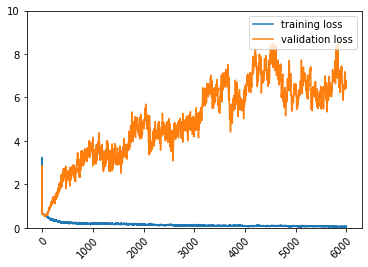

Epoch: 0000 loss_train: 0.9694 loss_val: 1.0076
Epoch: 0050 loss_train: 0.7618 loss_val: 0.9323
Epoch: 0100 loss_train: 0.6669 loss_val: 1.0942
Epoch: 0150 loss_train: 0.6473 loss_val: 1.0341
Epoch: 0200 loss_train: 0.5449 loss_val: 1.2524
Epoch: 0250 loss_train: 0.4883 loss_val: 1.3133
Epoch: 0300 loss_train: 0.4792 loss_val: 1.5683
Epoch: 0350 loss_train: 0.3984 loss_val: 1.5945
Epoch: 0400 loss_train: 0.3750 loss_val: 1.6249
Epoch: 0450 loss_train: 0.3536 loss_val: 1.7030
Epoch: 0500 loss_train: 0.3159 loss_val: 1.9703
Epoch: 0550 loss_train: 0.3403 loss_val: 1.9841
Epoch: 0600 loss_train: 0.2873 loss_val: 2.2363
Epoch: 0650 loss_train: 0.3023 loss_val: 2.1104
Epoch: 0700 loss_train: 0.2426 loss_val: 2.1400
Epoch: 0750 loss_train: 0.2531 loss_val: 2.3038
Epoch: 0800 loss_train: 0.2048 loss_val: 2.5189
Epoch: 0850 loss_train: 0.2342 loss_val: 2.5526
Epoch: 0900 loss_train: 0.2105 loss_val: 2.9228
Epoch: 0950 loss_train: 0.2209 loss_val: 2.9373
Epoch: 1000 loss_train: 0.2382 loss_val:

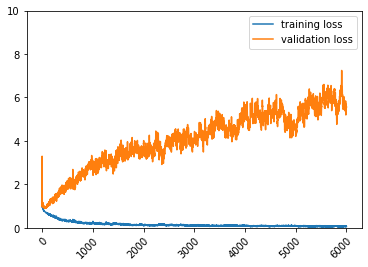

Epoch: 0000 loss_train: 0.7619 loss_val: 0.7822
Epoch: 0050 loss_train: 0.6145 loss_val: 0.6429
Epoch: 0100 loss_train: 0.5583 loss_val: 0.6608
Epoch: 0150 loss_train: 0.5152 loss_val: 0.7019
Epoch: 0200 loss_train: 0.4352 loss_val: 0.8273
Epoch: 0250 loss_train: 0.4090 loss_val: 0.8822
Epoch: 0300 loss_train: 0.3691 loss_val: 0.9558
Epoch: 0350 loss_train: 0.3348 loss_val: 1.0387
Epoch: 0400 loss_train: 0.2965 loss_val: 1.2051
Epoch: 0450 loss_train: 0.2971 loss_val: 1.2116
Epoch: 0500 loss_train: 0.2636 loss_val: 1.2373
Epoch: 0550 loss_train: 0.2408 loss_val: 1.4781
Epoch: 0600 loss_train: 0.2652 loss_val: 1.3922
Epoch: 0650 loss_train: 0.2061 loss_val: 1.5475
Epoch: 0700 loss_train: 0.2250 loss_val: 1.6801
Epoch: 0750 loss_train: 0.2178 loss_val: 1.6208
Epoch: 0800 loss_train: 0.2213 loss_val: 1.7903
Epoch: 0850 loss_train: 0.1941 loss_val: 1.8473
Epoch: 0900 loss_train: 0.2124 loss_val: 1.8839
Epoch: 0950 loss_train: 0.2005 loss_val: 1.9095
Epoch: 1000 loss_train: 0.1867 loss_val:

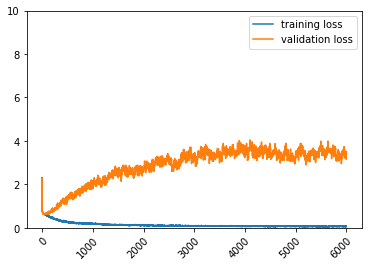

Epoch: 0000 loss_train: 0.9675 loss_val: 0.9817
Epoch: 0050 loss_train: 0.7717 loss_val: 0.7738
Epoch: 0100 loss_train: 0.6483 loss_val: 0.8542
Epoch: 0150 loss_train: 0.5241 loss_val: 0.9582
Epoch: 0200 loss_train: 0.4873 loss_val: 1.1469
Epoch: 0250 loss_train: 0.3968 loss_val: 1.3332
Epoch: 0300 loss_train: 0.3424 loss_val: 1.6290
Epoch: 0350 loss_train: 0.2759 loss_val: 1.7101
Epoch: 0400 loss_train: 0.3097 loss_val: 1.6573
Epoch: 0450 loss_train: 0.3236 loss_val: 1.6987
Epoch: 0500 loss_train: 0.2975 loss_val: 1.5968
Epoch: 0550 loss_train: 0.2718 loss_val: 1.9179
Epoch: 0600 loss_train: 0.2688 loss_val: 1.9637
Epoch: 0650 loss_train: 0.2268 loss_val: 2.2115
Epoch: 0700 loss_train: 0.2023 loss_val: 2.1310
Epoch: 0750 loss_train: 0.2010 loss_val: 2.1495
Epoch: 0800 loss_train: 0.2249 loss_val: 2.3529
Epoch: 0850 loss_train: 0.1721 loss_val: 2.4287
Epoch: 0900 loss_train: 0.2267 loss_val: 2.5653
Epoch: 0950 loss_train: 0.1552 loss_val: 2.9133
Epoch: 1000 loss_train: 0.2153 loss_val:

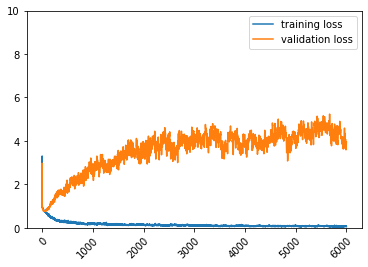

Epoch: 0000 loss_train: 1.0194 loss_val: 0.9922
Epoch: 0050 loss_train: 0.8017 loss_val: 0.7040
Epoch: 0100 loss_train: 0.6472 loss_val: 0.7381
Epoch: 0150 loss_train: 0.4984 loss_val: 0.9936
Epoch: 0200 loss_train: 0.4323 loss_val: 0.9903
Epoch: 0250 loss_train: 0.3841 loss_val: 1.0708
Epoch: 0300 loss_train: 0.3383 loss_val: 1.1613
Epoch: 0350 loss_train: 0.2998 loss_val: 1.0824
Epoch: 0400 loss_train: 0.2862 loss_val: 1.1387
Epoch: 0450 loss_train: 0.3102 loss_val: 1.1577
Epoch: 0500 loss_train: 0.2546 loss_val: 1.4127
Epoch: 0550 loss_train: 0.2235 loss_val: 1.5528
Epoch: 0600 loss_train: 0.2075 loss_val: 1.5355
Epoch: 0650 loss_train: 0.1999 loss_val: 1.4686
Epoch: 0700 loss_train: 0.1851 loss_val: 1.5229
Epoch: 0750 loss_train: 0.1874 loss_val: 1.4791
Epoch: 0800 loss_train: 0.2002 loss_val: 1.5577
Epoch: 0850 loss_train: 0.1863 loss_val: 1.6963
Epoch: 0900 loss_train: 0.1778 loss_val: 1.5908
Epoch: 0950 loss_train: 0.1713 loss_val: 1.5302
Epoch: 1000 loss_train: 0.1932 loss_val:

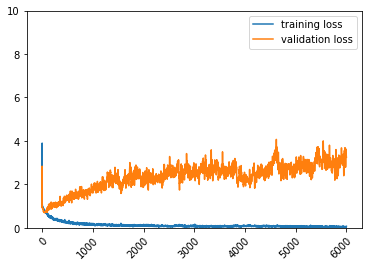

In [28]:
pctVal=0.05
pctTest=0.1

for i in np.unique(clusterRes):
    logsavepath_i=os.path.join(logsavepath,str(i))
    plotsavepath_i=os.path.join(plotsavepath,str(i))
    modelsavepath_i=os.path.join(modelsavepath,str(i))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==i]):
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==i,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==i,alllabels_sub==i_sub)]

        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        fig, ax = plt.subplots()
        plt.bar(trainLabels,traincounts)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        plt.savefig(os.path.join(plotsavepath_sub,'labelCounts.jpg'))

        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

        for ep in range(epochs):
        # for ep in range(10000,20000):

            train_loss_ep[ep],val_loss_ep[ep]=train(ep)


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_sub,str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))
        with open(os.path.join(logsavepath_sub,'train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_sub,'val_loss'), 'wb') as output:
            pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        plt.plot(np.arange(epochs),train_loss_ep)
        plt.plot(np.arange(epochs),val_loss_ep)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.ylim(0,10)
        plt.savefig(os.path.join(plotsavepath_sub,'loss_seed3.jpg'))
        plt.show()



In [35]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [38]:
torch.nn.functional.sigmoid(pred)

/usr/lib/python3/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[4.6589e-18],
        [1.0000e+00],
        [0.0000e+00],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00]], device='cuda:0')

In [48]:
#test loss
ep=5800

for c in np.unique(clusterRes):
    print(c)
    logsavepath_i=os.path.join(logsavepath,str(c))
    plotsavepath_i=os.path.join(plotsavepath,str(c))
    modelsavepath_i=os.path.join(modelsavepath,str(c))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==c]):
        print(i_sub)
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==c,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==c,alllabels_sub==i_sub)]

    
        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        model.load_state_dict(torch.load(os.path.join(modelsavepath_sub,str(ep)+'.pt')))
        predtest=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_test_all=0
            ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
            for i in range(ntestBatches):
                testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
                testInput=torch.tensor(stats_sub[testIdx_i])
                if use_cuda:
                    testInput=testInput.cuda().float()
                    labels=torch.tensor(labels_sub[testIdx_i]).cuda().float()
                pred = model(testInput)
                predtest=np.concatenate((predtest,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_test=lossCE(pred.flatten(),labels).item()

                loss_test_all+=loss_test

            loss_test_all=loss_test_all/ntestBatches

        print('test loss: '+str(loss_test_all))

        plotCTcomp(labels_sub[testIdx],predtest,plotsavepath_sub,'confusion_test',False)

        predtrain=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_train_all=0
            ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
            for i in range(ntrainBatches):
                trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
                trainInput=torch.tensor(stats_sub[trainIdx_i])
                if use_cuda:
                    trainInput=trainInput.cuda().float()
                    labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
                pred = model(trainInput)
                predtrain=np.concatenate((predtrain,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_train=lossCE(pred.flatten(),labels).item()

                loss_train_all+=loss_train

            loss_train_all=loss_train_all/ntrainBatches

        print('train loss: '+str(loss_train_all))
        plotCTcomp(labels_sub[trainIdx],predtrain,plotsavepath_sub,'confusion_train',False)

0
0.0
test loss: 4.979102611541748
train loss: 0.005817369092255831
1.0
test loss: 9.896221160888672
train loss: 0.05502654239535332
2.0
test loss: 4.939205169677734
train loss: 0.019341275095939636
3.0
test loss: 3.363251209259033
train loss: 0.00506824254989624
1
0.0
test loss: 6.654127597808838
train loss: 0.09673270583152771
1.0
test loss: 6.281834125518799
train loss: 0.5287895202636719
2.0
test loss: 6.18285608291626
train loss: 0.6564047932624817
3.0
test loss: 4.485424518585205
train loss: 0.4206441342830658
4.0
test loss: 11.613189697265625
train loss: 0.14959469437599182
5.0
test loss: 4.4346537590026855
train loss: 0.1696060299873352
2
0.0
test loss: 4.769069671630859
train loss: 0.0038113482296466827
1.0
test loss: 6.222830772399902
train loss: 0.03055039420723915
2.0
test loss: 4.649371147155762
train loss: 0.04447586461901665
3.0
test loss: 3.316521406173706
train loss: 0.016622137278318405
4.0
test loss: 5.777074337005615
train loss: 0.01689952425658703
5.0
test loss: 9.

In [41]:
np.sum(np.logical_and(alllabels==i,alllabels_sub==i_sub))

0

In [42]:
i

0

In [43]:
i_sub

4.0

In [44]:
np.unique(alllabels_sub[alllabels==i])

array([0., 1., 2., 3.])